# Blueprint Power Modeling Engineer Interview Project

Stephen Klosterman

steve.klosterman@gmail.com

11/7/2018

In [1]:
#Load packages
import pulp
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import datetime
import pytz
%matplotlib inline 

In [2]:
#Define constants from requirements document
zone_of_interest = 'N.Y.C.'
max_discharge_power_capacity = 100 #(kW)
max_charge_power_capacity = 100 #(kW)
discharge_energy_capacity = 200 #(kWh)
efficiency = 0.85 #unitless
max_daily_discharged_throughput = 200  #(kWh)

In [3]:
#Assume the battery is half-way charged to start
initial_level = discharge_energy_capacity/2
initial_level

100

## Problem and approach

The task is to formulate an operation strategy for a grid connected battery system, to perform energy arbitrage on the NYISO day ahead market. I will assume that the system operates on publicly available information. The NYISO makes the next day's hourly energy prices available at 11am each day ([NYISO Day-Ahead Scheduling Manual](http://www.nyiso.com/public/webdocs/markets_operations/documents/Manuals_and_Guides/Manuals/Operations/dayahd_schd_mnl.pdf) page 2-4). The system design will schedule the next 24 hours of battery operation (noon of the current day through the 11am hour of the next day) using this information, in order to use the most up-to-date prices. I will assume that after the daily price announcement from the NYISO, the next 36 hours of price information are available: the prices for the remaining 12 hours of the current day, as well as 24 hours worth of prices for the next day. Therefore the optimization time horizon will be 36 hours, to take advantage of all available future price information.

The battery is a price taker, meaning its activities do not affect the price of energy. The price paid for power to charge the battery, and revenue from discharging, is the location based marginal price (LBMP), which takes in to account the system marginal price, congestion component, and marginal loss component ([Locational Marginal Pricing Components](https://www.pjm.com/-/media/training/nerc-certifications/markets-exam-materials/mkt-optimization-wkshp/locational-marginal-pricing-components.ashx?la=en)). The goal is to maximize profit, given the day ahead prices and the battery system's parameters.

In this scenario, where future prices are known and the battery system is a price taker, the problem can be solved by linear programming (Salles et al. 2017, Sioshansi et al. 2009, Wang and Zhang 2018). Loosely following the notation of Sioshansi et al. (2009), the objective is to maximize profit:

$$ \text{max} \sum_{t=12\text{pm of current day}}^{11\text{pm of next day}} p_t \cdot (d_t - c_t)$$

where $p_t$ is the LBMP (\$/MWh) and $d_t$ and $c_t$ are the discharging and charging power flows, respectively (kW), all at time $t$, which will be an hourly time step. This objective maximizes profit for a time period starting at noon the current day, through the 11pm hour the next day (i.e. up until immediately before midnight the next day). The objective is subject to a battery storage constraint:

$$ 0 <= \sum_{t_f = 1\text{pm of current day}}^{11\text{pm of next day}} \sum_{t=12\text{pm of current day}}^{t_f} s_{i} + \eta \cdot
c_t - d_t <= \text{discharge energy capacity (kWh)}$$

where $s_i$ is the state of energy (kWh) of the battery at the start of the 36-hour optimization period and $\eta$ is the round-trip efficiency of the battery. This constraint requires the battery's state of energy (sum of initial state and hourly power flows) to be between zero, assuming the battery has complete depth of discharge capabilities, and the battery's discharge energy capacity, for each hour of the optimization horizon. In this constraint, the power flows (kW) are understood to be converted to units of energy (kWh) through multiplication by the one hour time step.

The charge flows are governed by

$$ c_t, d_t < \kappa, \forall t $$

where $\kappa$ (kW) is the maximum charge and discharge power capacity, assumed equal for this problem, and maximum daily discharged throughput $\tau$ (kWh):

$$ \sum_{t=12\text{pm of current day}}^{11\text{am of next day}} d_t <= \tau$$

$$ \sum_{t=12\text{pm of next day}}^{11\text{pm of next day}} d_t <= 0.5 \cdot \tau$$

In this notebook I will import the price data for solving the problem, set up and solve the optimization using the PuLP library for linear programming, and examine the optimal battery dispatch strategy.

# Load data
The data is supplied as LBMPs for several zones, at an hourly time step throughout 2017. Here I load the CSV files (one per day) and concatenate them on to a DataFrame.

In [4]:
#Directory of data supplied with problem
data_dir = '../2017_NYISO_LBMPs/'

In [5]:
dir_list = os.listdir(data_dir)
dir_list.sort()
dir_list

['.DS_Store',
 '20170101damlbmp_zone_csv',
 '20170201damlbmp_zone_csv',
 '20170301damlbmp_zone_csv',
 '20170401damlbmp_zone_csv',
 '20170501damlbmp_zone_csv',
 '20170601damlbmp_zone_csv',
 '20170701damlbmp_zone_csv',
 '20170801damlbmp_zone_csv',
 '20170901damlbmp_zone_csv',
 '20171001damlbmp_zone_csv',
 '20171101damlbmp_zone_csv',
 '20171201damlbmp_zone_csv']

In [6]:
#Remove invisible files (i.e. .DS_Store used by Mac OS)
for this_item in dir_list:
    if this_item[0] == '.':
        dir_list.remove(this_item)

Loop through all the subdirectories, loading all the CSV files.

In [7]:
tic = time.time()
#count loaded files
file_counter = 0

#For each subdirectory in the parent directory
for this_sub_dir in dir_list:
    #List the files
    this_sub_dir_list = os.listdir(data_dir + '/' + this_sub_dir)
    #Sort the list
    this_sub_dir_list.sort()
    #Delete invisible files (that start with '.')
    for this_item in this_sub_dir_list:
        if this_item[0] == '.':
            this_sub_dir_list.remove(this_item)
    #For each file in the subdirectory
    for this_file in this_sub_dir_list:
        #Load the contents into a DataFrame
        this_df = pd.read_csv(data_dir + '/' + this_sub_dir + '/' + this_file)#,
        #Concatenate with existing data if past first file
        if file_counter == 0:
            all_data = this_df.copy()
        else:
            all_data = pd.concat([all_data, this_df])
        
        file_counter += 1
toc = time.time()
print(str(toc-tic) + ' seconds run time')

1.71664500237 seconds run time


Examine the data

In [8]:
all_data.head()

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0  01/01/2017 00:00  CAPITL  61757          42.06   
1  01/01/2017 00:00  CENTRL  61754          15.50   
2  01/01/2017 00:00  DUNWOD  61760          33.52   
3  01/01/2017 00:00  GENESE  61753          14.67   
4  01/01/2017 00:00     H Q  61844          11.89   

   Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
0                           0.68                             -29.05  
1                           0.20                              -2.98  
2                           1.13                             -20.06  
3                           0.04                              -2.31  
4                          -0.43                               0.00

Sanity checks on data. Were 365 days of data loaded?

In [9]:
file_counter == 365

True

How many zones are there, and what are they?

In [10]:
unique_names = all_data['Name'].unique()
print(len(unique_names))
unique_names

15


array(['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'H Q', 'HUD VL', 'LONGIL',
       'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'NPX', 'O H', 'PJM', 'WEST'], dtype=object)

How may rows are there?

In [11]:
all_data.shape

(131400, 6)

Check that number of rows = number of zones times 24 hours a day times 365 days a year:

In [12]:
15*24*365 == all_data.shape[0]

True

Select out the data of interest (specific zone):

In [13]:
all_data = all_data.loc[all_data['Name'].isin([zone_of_interest]),:]

In [14]:
all_data.shape

(8760, 6)

The DataFrame will be easier to use with a datetime index.
Reset the index to the time stamp:

In [15]:
all_data = all_data.set_index(['Time Stamp'])

Cast as datetime:

In [16]:
all_data.index = pd.to_datetime(all_data.index, format='%m/%d/%Y %H:%M')

Make it time zone aware:

In [17]:
all_data.index = \
all_data.index.tz_localize('America/New_York', ambiguous='infer')

Convert to Eastern Standard Time to get rid of daylight savings, so there are 24 hours in each day:

In [18]:
all_data.index = \
all_data.index.tz_convert('EST')

Demonstrate selection of data for time range. Note this is the day when Daylight Savings Time ended in 2017, which is confirmed to have 24 hours here and not 25 like in the raw data.

In [19]:
start_time = datetime.datetime(2017, 11, 4, 12, 0)
end_time = datetime.datetime(2017, 11, 5, 11, 0)

In [20]:
test = all_data[start_time:end_time]
test

Name   PTID  LBMP ($/MWHr)  \
Time Stamp                                                
2017-11-04 12:00:00-05:00  N.Y.C.  61761          19.28   
2017-11-04 13:00:00-05:00  N.Y.C.  61761          18.97   
2017-11-04 14:00:00-05:00  N.Y.C.  61761          18.97   
2017-11-04 15:00:00-05:00  N.Y.C.  61761          21.25   
2017-11-04 16:00:00-05:00  N.Y.C.  61761          23.66   
2017-11-04 17:00:00-05:00  N.Y.C.  61761          27.14   
2017-11-04 18:00:00-05:00  N.Y.C.  61761          23.88   
2017-11-04 19:00:00-05:00  N.Y.C.  61761          22.34   
2017-11-04 20:00:00-05:00  N.Y.C.  61761          21.28   
2017-11-04 21:00:00-05:00  N.Y.C.  61761          20.82   
2017-11-04 22:00:00-05:00  N.Y.C.  61761          14.36   
2017-11-04 23:00:00-05:00  N.Y.C.  61761          22.02   
2017-11-05 00:00:00-05:00  N.Y.C.  61761          19.38   
2017-11-05 01:00:00-05:00  N.Y.C.  61761          20.87   
2017-11-05 02:00:00-05:00  N.Y.C.  61761          20.43   
2017-11-05 03:00:00-05:00  N.Y.C.  61761          11.81   
2017-11-05 04:00:00-05:00  N.Y.C.  61761          13.13   
2017-11-05 05:00:00-05:00  N.Y.C.  61761          13.86   
2017-11-05 06:00:00-05:00  N.Y.C.  61761          14.03   
2017-11-05 07:00:00-05:00  N.Y.C.  61761          18.00   
2017-11-05 08:00:00-05:00  N.Y.C.  61761          20.94   
2017-11-05 09:00:00-05:00  N.Y.C.  61761          24.43   
2017-11-05 10:00:00-05:00  N.Y.C.  61761          25.55   
2017-11-05 11:00:00-05:00  N.Y.C.  61761          23.74   

                           Marginal Cost Losses ($/MWHr)  \
Time Stamp                                                 
2017-11-04 12:00:00-05:00                           2.17   
2017-11-04 13:00:00-05:00                           2.12   
2017-11-04 14:00:00-05:00                           2.16   
2017-11-04 15:00:00-05:00                           2.40   
2017-11-04 16:00:00-05:00                           2.56   
2017-11-04 17:00:00-05:00                           2.93   
2017-11-04 18:00:00-05:00                           2.63   
2017-11-04 19:00:00-05:00                           2.36   
2017-11-04 20:00:00-05:00                           1.95   
2017-11-04 21:00:00-05:00                           1.47   
2017-11-04 22:00:00-05:00                           1.06   
2017-11-04 23:00:00-05:00                           0.47   
2017-11-05 00:00:00-05:00                           0.45   
2017-11-05 01:00:00-05:00                           0.40   
2017-11-05 02:00:00-05:00                           0.34   
2017-11-05 03:00:00-05:00                           0.45   
2017-11-05 04:00:00-05:00                           0.43   
2017-11-05 05:00:00-05:00                           0.42   
2017-11-05 06:00:00-05:00                           0.59   
2017-11-05 07:00:00-05:00                           0.97   
2017-11-05 08:00:00-05:00                           1.20   
2017-11-05 09:00:00-05:00                           1.42   
2017-11-05 10:00:00-05:00                           1.42   
2017-11-05 11:00:00-05:00                           1.51   

                           Marginal Cost Congestion ($/MWHr)  
Time Stamp                                                    
2017-11-04 12:00:00-05:00                               0.00  
2017-11-04 13:00:00-05:00                               0.00  
2017-11-04 14:00:00-05:00                              -0.06  
2017-11-04 15:00:00-05:00                              -0.07  
2017-11-04 16:00:00-05:00                              -0.80  
2017-11-04 17:00:00-05:00                              -1.32  
2017-11-04 18:00:00-05:00                              -0.21  
2017-11-04 19:00:00-05:00                              -1.41  
2017-11-04 20:00:00-05:00                              -3.84  
2017-11-04 21:00:00-05:00                              -7.23  
2017-11-04 22:00:00-05:00                              -4.36  
2017-11-04 23:00:00-05:00                             -17.31  
2017-11-05 00:00:00-05:00                          

In [21]:
#Should be 24 rows (hours in this day)
test.shape

(24, 5)

Show how prices can be selected as a numpy array:

In [22]:
all_data[start_time:end_time]['LBMP ($/MWHr)'].values

array([ 19.28,  18.97,  18.97,  21.25,  23.66,  27.14,  23.88,  22.34,
        21.28,  20.82,  14.36,  22.02,  19.38,  20.87,  20.43,  11.81,
        13.13,  13.86,  14.03,  18.  ,  20.94,  24.43,  25.55,  23.74])

# Set up and solve the optimization problem

Define a function, 'smart_battery_model', that simulates the operation of the battery for energy arbitrage. The first input is the initial level of charge of the battery.

Business requirements indicate a modeling tool that takes several other inputs. These are the rest of the function inputs:

- Hourly LBMP ($/MWh) (contained in dataframe 'price_data')
- Max discharge power capacity (kW)
- Max charge power capacity (kW)
- Discharge energy capacity (kWh)
- AC-AC Round-trip efficiency (%)
- Maximum daily discharged throughput (kWh)

The function returns several outputs that can be used to examine system operation and meet requirements for the modeling tool:

- Charging and discharging activity, and state of energy, at an hourly time step
- Discharged throughput at a daily time step

In [23]:
def smart_battery_model(initial_level, price_data, max_discharge_power_capacity, \
                        max_charge_power_capacity, discharge_energy_capacity,
                        efficiency, max_daily_discharged_throughput):
    #Track simulation time
    tic = time.time()
    
    #Initialize output variables
    all_hourly_charges = np.empty(0)
    all_hourly_discharges = np.empty(0)
    all_hourly_state_of_energy = np.empty(0)
    all_daily_discharge_throughput = np.empty(0)
    
    #Set up decision variables for optimization
    #These are the hourly charge and discharge flows for the optimization horizon,
    #with their limitations.
    #"The battery storageâ€™s State of Energy SHALL be continuous between optimization time
    #horizon boundaries": note 'Continuous' decision variables
    charge = pulp.LpVariable.dicts("charging_power",
                                     ('c_t_' + str(i) for i in range(0,36)),
                                     lowBound=0, upBound=max_charge_power_capacity,
                                     cat='Continuous')
    discharge = pulp.LpVariable.dicts("discharging_power",
                                     ('d_t_' + str(i) for i in range(0,36)),
                                     lowBound=0, upBound=max_discharge_power_capacity,
                                     cat='Continuous')
    
    #364 24-hour periods (noon to noon) in simulation
    for day_count in range(0,364):
        
        #Step through the days, with 36 hour optimization horizon
        start_time = datetime.datetime(2017, 1, 1, 12, 0) \
        + datetime.timedelta(day_count)
        end_time = datetime.datetime(2017, 1, 2, 23, 0) \
        + datetime.timedelta(day_count)
        #print(start_time, end_time)
    
        #Retrieve the price data that will be used to calculate the objective
        prices = \
        price_data[start_time:end_time]['LBMP ($/MWHr)'].values
        
        #Catch if there are not 36 hours in a time window
        if len(prices) != 36:
            print(prices)
            print(start_time)
    
        #Instantiate linear programming model to maximize the objective
        model = pulp.LpProblem("Energy arbitrage", pulp.LpMaximize)
    
        #Objective is profit
        #This formula gives the daily profit from charging/discharging activities.
        #Charging is a cost, discharging is a revenue
        model += pulp.LpAffineExpression([(charge['c_t_' + str(i)],
                                                 -1*prices[i]) for i in range(0,36)]) +\
        pulp.LpAffineExpression([(discharge['d_t_' + str(i)],
                                                 prices[i]) for i in range(0,36)])
        
        #Storage level constraint 1
        #"The battery storage system has 100% depth of discharge capabilities"
        #This says the battery cannot have less than zero energy, at
        #any hour in the horizon
        #Note this is a place where round-trip efficiency is factored in.
        #The energy available for discharge is the round-trip efficiency
        #times the energy that was charged.
        min_capacity = 0
        
        for hour_of_day in range(1,37):
            model += \
                initial_level \
                + pulp.LpAffineExpression(
                    [(charge['c_t_' + str(i)], efficiency) for i in range(0,hour_of_day)]) \
                - pulp.lpSum(
                    discharge[index] for index in ('d_t_' + str(i)
                                                   for i in range(0,hour_of_day)))\
                >= min_capacity
            
        #Storage level constraint 2
        #Similar to 1
        #This says the battery cannot have more than the discharge energy capacity
        for hour_of_day in range(1,37):
            model += \
                initial_level \
                + pulp.LpAffineExpression(
                    [(charge['c_t_' + str(i)], efficiency) for i in range(0,hour_of_day)]) \
                - pulp.lpSum(
                    discharge[index] for index in ('d_t_' + str(i)
                                                   for i in range(0,hour_of_day)))\
                <= discharge_energy_capacity
            
        #Maximum discharge throughput constraint
        #The sum of all discharge flow within a day cannot exceed this
        #Half of the next day is included due to 36 hour horizon
        model += \
            pulp.lpSum(
                discharge[index] for index in ('d_t_' + str(i) for i in range(0,24))) \
            <= max_daily_discharged_throughput
        
        model += \
            pulp.lpSum(
                discharge[index] for index in ('d_t_' + str(i) for i in range(25,36))) \
            <= max_daily_discharged_throughput*0.5
            
        #Solve the optimization problem
        model.solve()
        
        #Show a warning if an optimal solution was not found
        if pulp.LpStatus[model.status] != 'Optimal':
            print('Warning: ' + pulp.LpStatus[model.status])
        
        ## Collect output
        #Collect hourly charging and discharging rates within the next 24 hours
        hourly_charges =\
            np.array(
                [charge[index].varValue for
                 index in ('c_t_' + str(i) for i in range(0,24))])
        hourly_discharges =\
            np.array(
                [discharge[index].varValue for
                 index in ('d_t_' + str(i) for i in range(0,24))])
        #Collect daily discharge throughput
        daily_discharge_throughput = sum(hourly_discharges)
        #Calculate net hourly power flow (kW), needed for state of energy.
        #Charging needs to factor in efficiency, as not all charged power is 
        #available for discharge.
        net_hourly_activity = (hourly_charges*efficiency) - hourly_discharges
        #Cumulative changes in energy over time (kWh) from some baseline
        cumulative_hourly_activity = np.cumsum(net_hourly_activity)
        #Add the baseline for hourly state of energy
        state_of_energy_from_t2 = initial_level + cumulative_hourly_activity
        
        #Initial level for next period is the end point of current period
        initial_level = state_of_energy_from_t2[-1]
        
        #Append output
        all_hourly_charges = np.append(all_hourly_charges, hourly_charges)
        all_hourly_discharges = np.append(all_hourly_discharges, hourly_discharges)
        all_hourly_state_of_energy = \
        np.append(all_hourly_state_of_energy, state_of_energy_from_t2)
        all_daily_discharge_throughput = \
        np.append(all_daily_discharge_throughput, daily_discharge_throughput)

    toc = time.time()
        
    print('Total simulation time: ' + str(toc-tic) + ' seconds')

    return all_hourly_charges, all_hourly_discharges, all_hourly_state_of_energy,\
        all_daily_discharge_throughput

Run the simulation

In [24]:
all_hourly_charges, all_hourly_discharges, all_hourly_state_of_energy,\
        all_daily_discharge_throughput = \
    smart_battery_model(initial_level, all_data, max_discharge_power_capacity,
                        max_charge_power_capacity, discharge_energy_capacity,
                        efficiency, max_daily_discharged_throughput)

Total simulation time: 28.4918179512 seconds


Sanity check: the number of simulated hours should be:

In [25]:
24*364 == len(all_hourly_discharges)

True

# Examine outputs
The modeling tool requirements include outputs of hourly
- Power output (kW)
- State of Energy (kWh)

Here they are graphed, and later attached to a DataFrame if further analysis is needed.

## Power output
Define power output with discharging as positive and charging as negative.

In [26]:
mpl.rcParams["figure.figsize"] = [5,3]
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams.update({"font.size":12})

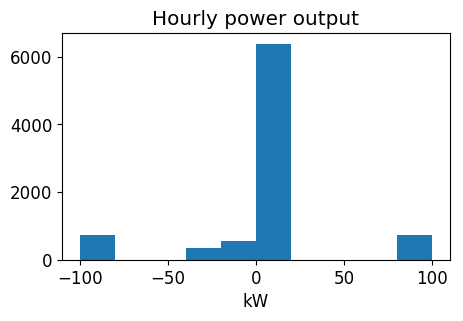

In [27]:
plt.hist(all_hourly_discharges - all_hourly_charges)
plt.xlabel('kW')
plt.title('Hourly power output')

This indicates that for most hours over the year, the power is close to zero. However it is also common for the battery to be operating at the limits of its range [-100, 100] kW.

## State of energy
The battery state of energy should be no less than zero, and no greater than the dicharge energy capcacity, at any time: [0, 200] kWh.

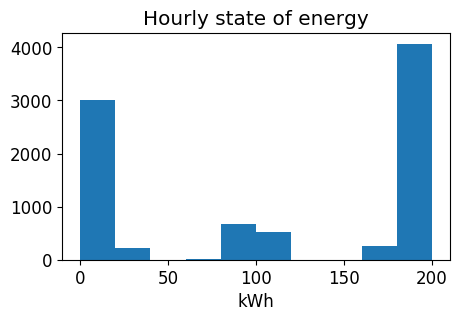

In [28]:
plt.hist(all_hourly_state_of_energy)
plt.xlabel('kWh')
plt.title('Hourly state of energy')

Results indicate the battery is operating within the prescribed limits of state of energy.

For the rest of the requirements,
- Total annual revenue generation (\$)
- Total annual charging cost (\$)
- Total annual discharged throughput (kWh)

it is convenient to put the data in a DataFrame

Select out a new dataframe based on the time frame of simulation, to report further results:

In [29]:
all_data_sim_time = all_data[datetime.datetime(2017, 1, 1, 12, 0):
                   datetime.datetime(2017, 12, 31, 11, 0)].copy()

Check there is the right number of rows:

In [30]:
all_data_sim_time.shape

(8736, 5)

In [31]:
all_data_sim_time.shape[0] == len(all_hourly_discharges)

True

Attach simulation results

In [32]:
#These indicate flows during the hour of the datetime index
all_data_sim_time['Charging power (kW)'] = all_hourly_charges
all_data_sim_time['Discharging power (kW)'] = all_hourly_discharges
all_data_sim_time['Power output (kW)'] = all_hourly_discharges - all_hourly_charges
#This is the state of power at the beginning of the hour of the datetime index 
all_data_sim_time['State of Energy (kWh)'] = np.append(initial_level, 
                                                       all_hourly_state_of_energy[0:-1])

Revenue and cost would be in units of
$\frac{\text{kW} \cdot \text{\$} \cdot \text{h}}{\text{MWh}} = 1000 \cdot \$$ , so divide by 1000 to adjust to $:

In [33]:
all_data_sim_time['Revenue generation ($)'] = \
all_data_sim_time['Discharging power (kW)'] * all_data_sim_time['LBMP ($/MWHr)'] / 1000

In [34]:
all_data_sim_time['Charging cost ($)'] = \
all_data_sim_time['Charging power (kW)'] * all_data_sim_time['LBMP ($/MWHr)'] / 1000

In [35]:
all_data_sim_time['Profit ($)'] = all_data_sim_time['Revenue generation ($)'] - \
all_data_sim_time['Charging cost ($)']

## Revenue, cost, and profit
What is the total annual revenue generation?

In [36]:
all_data_sim_time['Revenue generation ($)'].sum()

3367.7464993572917

Total annual charging cost?

In [37]:
all_data_sim_time['Charging cost ($)'].sum()

1824.087824055044

Calculate profit

In [38]:
all_data_sim_time['Profit ($)'].sum()

1543.6586753022518

The total annual revenue was \$3,368, cost was \$1,824, and profit was \$1,544.

## Total annual discharged throughput

Total annual discharged throughput (kWh) is a requirement of the modeling tool.

What is the sum of daily discharged throughput? This is limited to 200 kWh/day. If the battery discharged its maximum possible energy every day during the 364 day simulation, the total discharge would be:

In [39]:
364*200
#kWh

72800

And in fact it is:

In [40]:
sum(all_daily_discharge_throughput)

72799.999992000216

This implies the system is hitting the maximum discharged throughput limit every day, as confirmed by a histogram:

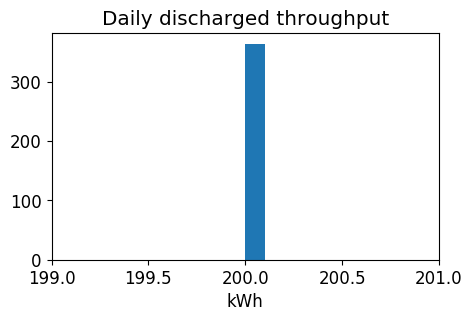

In [41]:
plt.hist(np.round(all_daily_discharge_throughput))
plt.xlim([199, 201])
plt.xlabel('kWh')
plt.title('Daily discharged throughput')

## Find the most profitable week
Group the profit column by week and locate the maximum

In [42]:
max_profit_week = (all_data_sim_time['Profit ($)'].resample('W').sum() == \
all_data_sim_time['Profit ($)'].resample('W').sum().max()).values

In [43]:
all_data_sim_time['Profit ($)'].resample('W').sum()[max_profit_week]

Time Stamp
2017-12-31 00:00:00-05:00    56.527353
Freq: W-SUN, Name: Profit ($), dtype: float64

The week ending on New Year's Eve, 2017, was the most profitable. For this week, make a graph of hourly battery dispatch and hourly LBMP.

In [44]:
mpl.rcParams["figure.figsize"] = [8,6]
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams.update({"font.size":14})

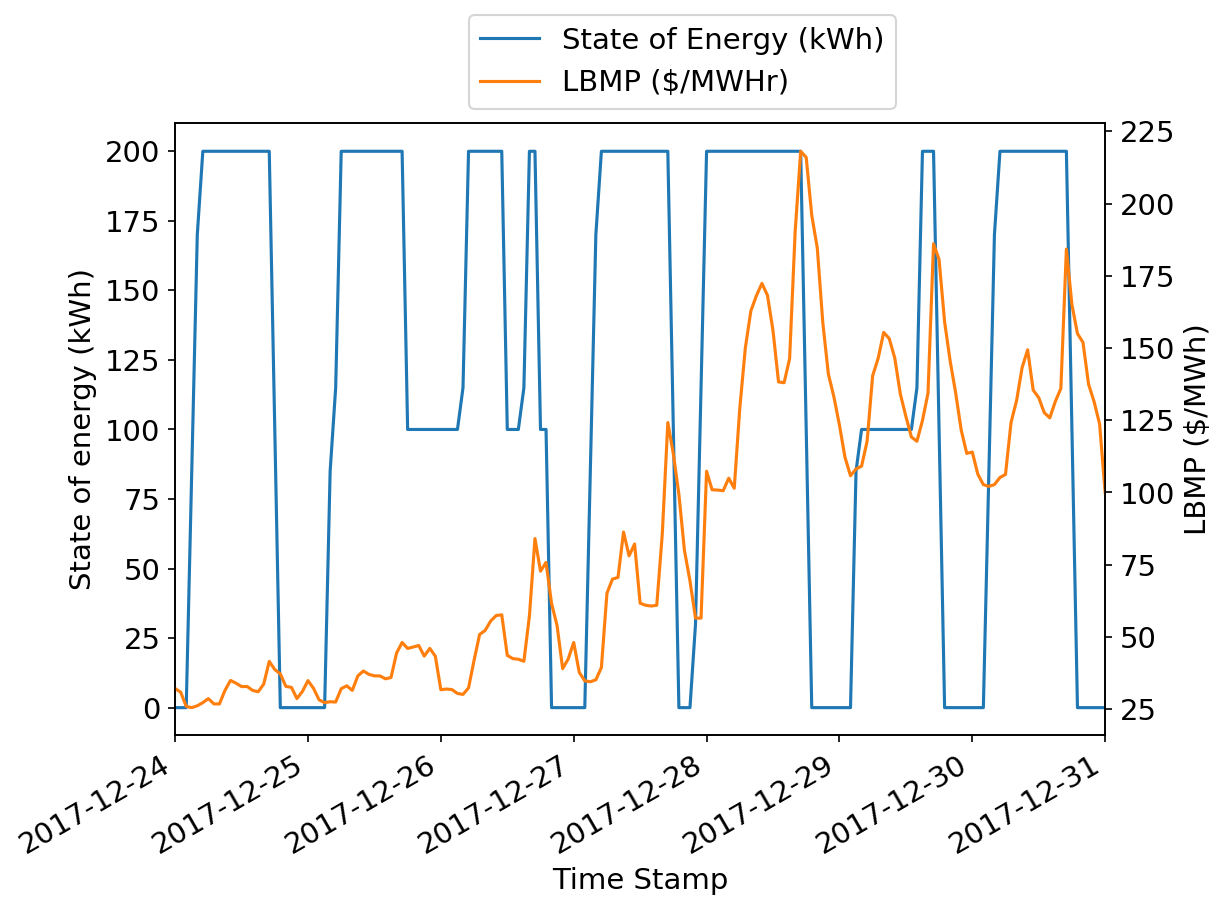

In [45]:
ax = all_data_sim_time['2017-12-24 00:00':'2017-12-31 00:00']\
[['State of Energy (kWh)', 'LBMP ($/MWHr)']]\
.plot(secondary_y='LBMP ($/MWHr)', mark_right=False)

ax.set_ylabel('State of energy (kWh)')
ax.right_ax.set_ylabel('LBMP ($/MWh)')
ax.get_legend().set_bbox_to_anchor((0.3, 1))

The battery appears to follow the general arbitrage srategy of "buy low, sell high", to take advantage of future price changes.

## Monthly profit

In [46]:
mpl.rcParams["figure.figsize"] = [6,4]
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams.update({"font.size":12})

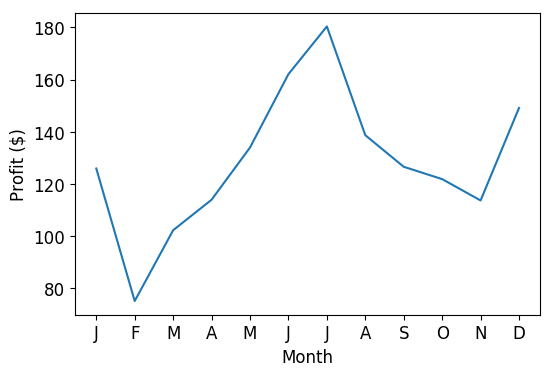

In [47]:
monthly_resample = all_data_sim_time['Profit ($)'].resample('M').sum().reset_index()
x = monthly_resample.index
y = monthly_resample['Profit ($)']
plt.plot(x,y)
plt.xticks(list(range(0,12)), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.xlabel('Month')
plt.ylabel('Profit ($)')

Profit is mostly higher in the summer than winter, but is also high in January and December. A plot of the LBMP throughout the year sheds some light on this:

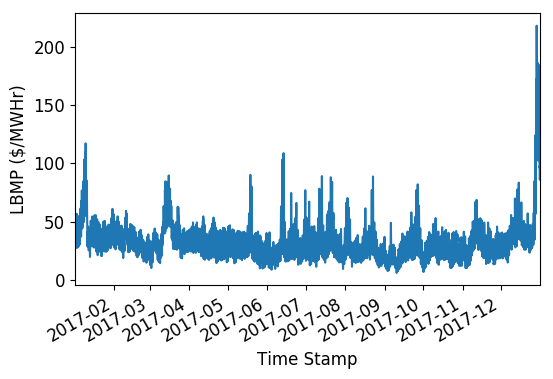

In [48]:
all_data_sim_time['LBMP ($/MWHr)'].plot()
plt.ylabel('LBMP ($/MWHr)')

Changes in price enable the arbitrage strategy to make profit. Generally, most of the larger price swings are during the summer months, probably reflecting increased demand due to air conditioning usage on hot summer days. But there are large price changes during mid-Januray, as well as late December. This may be due to tourism to New York City to celebrate the New Year, or cold weather that increases demand for electricity for heating.

# Conclusions

I find that an energy arbitrage strategy for a grid-connected battery, operating under the given parameters, can generate an annual total of $1,544 profit based on publicly available price data from 2017.

Further optimization for increased profit may be possible, if prices are able to be accurately predicted beyond the 36 hour optimization horizon used here. The NYISO price determination involves a load forecasting model, that depends on economic and weather factors. It may be possible to include such factors in a price forecasting model to estimate future day-ahead market prices that are not yet public.

Wang and Zhang (2018) review recent research on this topic, and show that reinforcement learning using historical price data can lead to higher profits than maximizing instantaneous profit, suggesting other possible approaches to maximizing profit from energy arbitrage.

# Milestones

Key milestones while I completed this project included:
- Finding the helpful references below about energy arbitrage with a grid-connected battery
- Locating the NYISO day-ahead scheduling manual online, and a training deck about LBMPs from the PJM
- Finding a helpful online tutorial for solving linear programming problems in Python with PuLP: http://benalexkeen.com/linear-programming-with-python-and-pulp-part-5/
- Clarifying my assumptions with Savannah
- Realizing I needed to constrain energy storage at every hour of the simulation, not just the end of each day, after diagnosing the issue with a histogram of hourly state of energy
- Realizing a 36 hour time horizon could take advantage of all available NYISO price information at any given time, and increase profit (\$1,544) over a 24 hour time horizon (\$1,067)

### References

Salles, Mauricio B. C., et al. 2017. Potential Arbitrage Revenue of Energy Storage Systems in PJM. Energies 10:8.

Sioshansi, Ramteen, et al. 2009. Estimating the Value of Electricity Storage in PJM: Arbitrage and Some Welfare Effects. Energy Economics 31:2, 269-277.

Wang, Hao and Zhang, Baosen, 2018. Energy Storage Arbitrage in Real-Time Markets via Reinforcement Learning. IEEE PES General Meeting.